In [515]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [516]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [517]:
NUM_CLASSES = 27

# Dataset reading

In [518]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [519]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [520]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.70, random_state=RANDOM_SEED)

In [521]:
from collections import deque

BUFFER_SIZE = 25  # Number of frames in the buffer

def reshape_for_lstm_with_buffer(data, labels, buffer_size=BUFFER_SIZE):
    frame_buffer = deque(maxlen=buffer_size)
    buffer_data = []
    buffer_labels = []

    # Create sequences of frames with corresponding labels
    for i in range(len(data) - buffer_size + 1):  # Adjust to match label size
        frame_buffer.append(data[i])
        if len(frame_buffer) == buffer_size:
            buffer_data.append(np.array(list(frame_buffer)))
            buffer_labels.append(labels[i + buffer_size - 1])  # Get the label for the last frame in the sequence

    return np.array(buffer_data), np.array(buffer_labels)

# Reshape both train and test data
X_train_reshaped, y_train_reshaped = reshape_for_lstm_with_buffer(X_train, y_train)
X_test_reshaped, y_test_reshaped = reshape_for_lstm_with_buffer(X_test, y_test)



# Model building

In [522]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(BUFFER_SIZE, 21, 2)),  # Input shape (25 frames, 21 keypoints, 2 features)
    tf.keras.layers.Reshape((BUFFER_SIZE, 42)),  # Flatten the last two dimensions (21*2=42)
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')  # Output layer for multi-class classification
])



In [523]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 25, 42)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 32)             │         9,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 20)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 27)             │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,767 (42.06 KB)

 Trainable params: 10,767 (42.06 KB)

 Non-trainable params: 0 (0.00 B)

In [524]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [525]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [528]:
model.fit(
    X_train_reshaped,  # Use reshaped data
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test_reshaped, y_test),  # Use reshaped test data
    callbacks=[cp_callback, es_callback]
)

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 38426
'y' sizes: 38474


In [ ]:
val_loss, val_acc = model.evaluate(X_test_reshaped, y_test, batch_size=128)

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9984 - loss: 0.0083


In [ ]:
model = tf.keras.models.load_model(model_save_path)

In [ ]:
test_sample = X_test[0].reshape(1, 21, 2)
predict_result = model.predict(test_sample)
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 3.6983399e-26 3.3256115e-31 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 1.6413015e-21 0.0000000e+00 7.4480557e-19
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 9.9992895e-01 0.0000000e+00
 7.1047580e-05 9.6621710e-27]
23


# Confusion matrix

516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


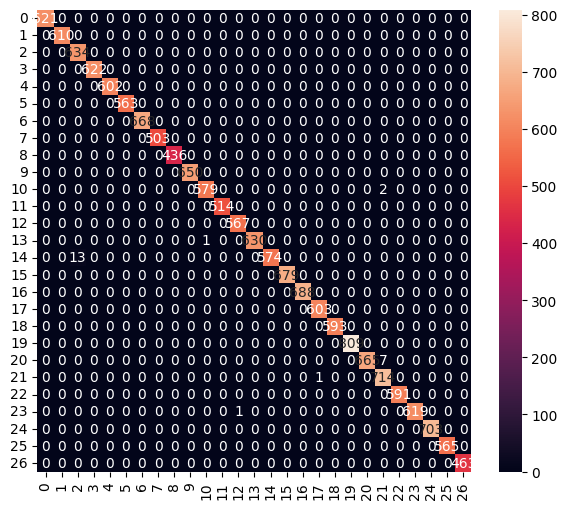

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       621
           1       1.00      1.00      1.00       610
           2       0.98      1.00      0.99       634
           3       1.00      1.00      1.00       622
           4       1.00      1.00      1.00       602
           5       1.00      1.00      1.00       563
           6       1.00      1.00      1.00       668
           7       1.00      1.00      1.00       503
           8       1.00      1.00      1.00       436
           9       1.00      1.00      1.00       650
          10       1.00      1.00      1.00       581
          11       1.00      1.00      1.00       514
          12       1.00      1.00      1.00       567
          13       1.00      1.00      1.00       631
          14       1.00      0.98      0.99       587
          15       1.00      1.00      1.00       679
          16       1.00      1.00      1.00       688
     

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report


def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test_reshaped)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [ ]:
model.save(model_save_path, include_optimizer=False)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)


converter.experimental_enable_resource_variables = True

converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]

converter._experimental_lower_tensor_list_ops = False

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_quantized_model = converter.convert()


with open(tflite_save_path, 'wb') as f:
    f.write(tflite_quantized_model)

print(f"TFLite model saved to: {tflite_save_path}")


INFO:tensorflow:Assets written to: C:\Users\ISHABR~1\AppData\Local\Temp\tmpv07ufuts\assets


INFO:tensorflow:Assets written to: C:\Users\ISHABR~1\AppData\Local\Temp\tmpv07ufuts\assets


Saved artifact at 'C:\Users\ISHABR~1\AppData\Local\Temp\tmpv07ufuts'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 21, 2), dtype=tf.float32, name='input_layer_13')
Output Type:
  TensorSpec(shape=(None, 27), dtype=tf.float32, name=None)
Captures:
  2249687279632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2249687280016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2249687280592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2249687272528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2249687278672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2249687280400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2249687277520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2249718437968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2249718436240: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ TFLite model saved to: model/keypoint_classifier/keypoint_classifier.tfli

# Inference test

In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [ ]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
interpreter.set_tensor(input_details[0]['index'], X_test_reshaped[0:1])

In [ ]:

interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

In [ ]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.84494626e-26 4.13612263e-31 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.15518799e-21 0.00000000e+00 8.87276732e-19 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 9.99925256e-01
 0.00000000e+00 7.47093072e-05 1.27045594e-26]
23
